In [94]:
import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
from urllib.parse import urlparse
import ipaddress as ip
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv("URL_dataset.csv")
df = df.sample(frac=1).reset_index(drop=True)
print("Total records: ",len(df))
df.head()

Total records:  7030


,URL,Lable
0,http://www.numerical-methods.com/,0
1,http://www.eshinejewelry.com/,0
2,http://www.chrismonroephoto.com/w/,1
3,http://bit.ly/2iffhNV,1
4,http://www.tableandvine.com/,0


In [72]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')

# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1    
    return count

#method to check the presence of hyphens
def isPresentHyphen(url):
    return url.count('-')

#method to check the presence of @
def isPresentAt(url):
    return url.count('@')

def isPresentDSlash(url):
    return url.count('//')

def countSubDir(url):
    return url.count('/')

def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))
    
def get_ext(url):
    root, ext = splitext(url)
    return ext

# Is IP addr present as th hostname, let's validate
def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0

In [73]:
Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']

featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

In [74]:
def getFeatures(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
    
    result.append(str(label))
    return result

In [75]:
for i in range(len(df)):
    features = getFeatures(df["URL"].loc[i], df["Lable"].loc[i])    
    featureSet.loc[i] = features

In [76]:
featureSet.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP,presence of Suspicious_TLD,presence of suspicious domain,label
0,http://www.numerical-methods.com/,0,1,33,0,0,1,1,25,0,0,0,0,0
1,http://www.eshinejewelry.com/,0,0,29,0,0,1,1,21,0,0,0,0,0
2,http://www.chrismonroephoto.com/w/,0,0,34,0,0,2,1,24,0,0,0,0,1
3,http://bit.ly/2iffhNV,0,0,21,0,0,1,0,6,0,0,0,0,1
4,http://www.tableandvine.com/,0,0,28,0,0,1,1,20,0,0,0,0,0


In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl

Text(0.5, 0, 'Length of URL')

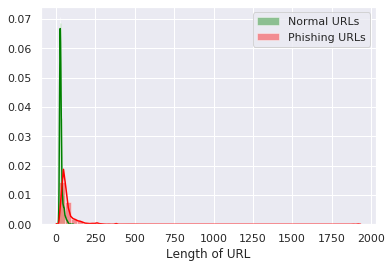

In [78]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of url'],color='green',label='Normal URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of url'],color='red',label='Phishing URLs')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

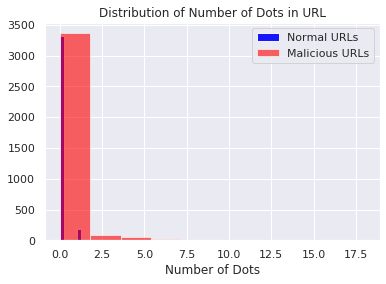

In [79]:
x=featureSet[featureSet['label']=='0']['no of dots']
y=featureSet[featureSet['label']=='1']['no of dots']
plt.hist(x,bins=8, alpha=0.9, label='Normal URLs',color='blue')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.show()

Text(0.5, 0, 'Length of Domain/Host')

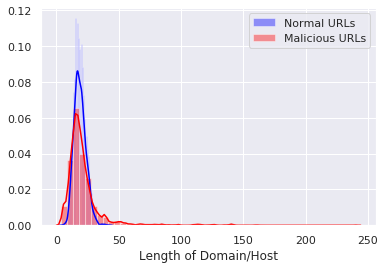

In [80]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of domain'],color='blue',label='Normal URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of domain'],color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')

In [81]:
## Number of Normal and Phishing URL's
featureSet.groupby(featureSet['label']).size()

label
0    3494
1    3536
dtype: int64

In [82]:
X = featureSet.drop(['url','label'],axis=1).values
y = featureSet['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

## Classification Models

- Logistic Regression
- Gaussian Naive Bayes
- Decision Tree Classifier
- Random Forest Classifier
- AdaBoostClassifier

### Logistic Regression

Accuracy: 0.84850640113798
Cross-Validation Score 0.8453101395043078


Text(0.5, 1, 'Confusion Matrix')

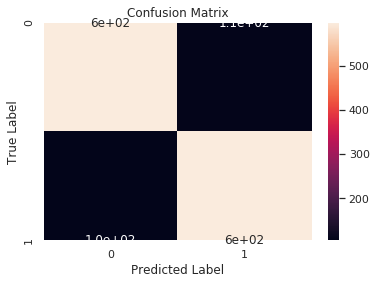

In [116]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_predicted = lr.predict(X_test)
lr_acc = accuracy_score(y_test,lr_predicted)
print("Accuracy:",lr_acc)

lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
print('Cross-Validation Score', lr_scores.mean())

conf_matrix = confusion_matrix(y_test, lr_predicted)
sns.heatmap(conf_matrix,annot=True,cbar=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [101]:
confusion_matrix(y_test, lr_predicted)

tp_lr = confusion_matrix(y_test, lr_predicted)[0,0]
fp_lr = confusion_matrix(y_test, lr_predicted)[0,1]
tn_lr = confusion_matrix(y_test, lr_predicted)[1,1]
fn_lr = confusion_matrix(y_test, lr_predicted)[1,0]

precison_lr = tp_lr/(tp_lr+fp_lr)
recall_lr = tp_lr/(tp_lr+fn_lr)

print("Precision: ", precison_lr)
print("Recall: ", recall_lr)

Precision:  0.8465909090909091
Recall:  0.8502139800285307


### Gaussian Naive Bayes 

In [117]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)
GNB_predicted = GNB.predict(X_test)
GNB_acc = accuracy_score(y_test,GNB_predicted)
print("Accuracy:",GNB_acc)

GNB_scores = cross_val_score(GNB, X_train, y_train, cv=10)
print('Cross-Validation Score', GNB_scores.mean())

Accuracy: 0.7027027027027027
Cross-Validation Score 0.6621656985012926


In [104]:
confusion_matrix(y_test, GNB_predicted)

array([[695,   9],
       [409, 293]])

In [105]:
tp_GNB = confusion_matrix(y_test, GNB_predicted)[0,0]
fp_GNB = confusion_matrix(y_test, GNB_predicted)[0,1]
tn_GNB = confusion_matrix(y_test, GNB_predicted)[1,1]
fn_GNB = confusion_matrix(y_test, GNB_predicted)[1,0]

precison_GNB = tp_GNB/(tp_GNB+fp_GNB)
recall_GNB = tp_GNB/(tp_GNB+fn_GNB)

print("Precision: ", precison_GNB)
print("Recall: ", recall_GNB)

Precision:  0.9872159090909091
Recall:  0.6295289855072463


### Decision Tree Classifier

In [118]:
DTC = tree.DecisionTreeClassifier(max_depth=10)
DTC.fit(X_train, y_train)
DTC_predicted = DTC.predict(X_test)
DTC_acc = accuracy_score(y_test,DTC_predicted)
print("Accuracy:",DTC_acc)

DTC_scores = cross_val_score(DTC, X_train, y_train, cv=10)
print('Cross-Validation Score', DTC_scores.mean())

Accuracy: 0.9011379800853485
Cross-Validation Score 0.8954431963995626


In [108]:
confusion_matrix(y_test, DTC_predicted)

array([[634,  70],
       [ 70, 632]])

In [109]:
tp_DTC = confusion_matrix(y_test, DTC_predicted)[0,0]
fp_DTC = confusion_matrix(y_test, DTC_predicted)[0,1]
tn_DTC = confusion_matrix(y_test, DTC_predicted)[1,1]
fn_DTC = confusion_matrix(y_test, DTC_predicted)[1,0]

precison_DTC = tp_DTC/(tp_DTC+fp_DTC)
recall_DTC = tp_DTC/(tp_DTC+fn_DTC)

print("Precision: ", precison_DTC)
print("Recall: ", recall_DTC)

Precision:  0.9005681818181818
Recall:  0.9005681818181818


### Random Forest Classifier

In [119]:
RFC = ek.RandomForestClassifier(max_depth=10)
RFC.fit(X_train, y_train)
RFC_predicted = RFC.predict(X_test)
RFC_acc = accuracy_score(y_test,RFC_predicted)
print("Accuracy:",RFC_acc)

RFC_scores = cross_val_score(RFC, X_train, y_train, cv=10)
print('Cross-Validation Score', RFC_scores.mean())

Accuracy: 0.903271692745377
Cross-Validation Score 0.9032723778942244


In [111]:
confusion_matrix(y_test, RFC_predicted)

array([[631,  73],
       [ 63, 639]])

In [112]:
tp_RFC = confusion_matrix(y_test, RFC_predicted)[0,0]
fp_RFC = confusion_matrix(y_test, RFC_predicted)[0,1]
tn_RFC = confusion_matrix(y_test, RFC_predicted)[1,1]
fn_RFC = confusion_matrix(y_test, RFC_predicted)[1,0]

precison_RFC = tp_RFC/(tp_RFC+fp_RFC)
recall_RFC = tp_RFC/(tp_RFC+fn_RFC)

print("Precision: ", precison_RFC)
print("Recall: ", recall_RFC)

Precision:  0.8963068181818182
Recall:  0.909221902017291


### AdaBoostClassifier

In [120]:
ABC = ek.AdaBoostClassifier(n_estimators=50)
ABC.fit(X_train, y_train)
ABC_predicted = ABC.predict(X_test)
ABC_acc = accuracy_score(y_test,ABC_predicted)
print("Accuracy:",ABC_acc)

ABC_scores = cross_val_score(ABC, X_train, y_train, cv=10)
print('Cross-Validation Score', ABC_scores.mean())

Accuracy: 0.8897581792318634
Cross-Validation Score 0.8723333312263358


In [114]:
confusion_matrix(y_test, ABC_predicted)

array([[621,  83],
       [ 72, 630]])

In [115]:
tp_ABC = confusion_matrix(y_test, ABC_predicted)[0,0]
fp_ABC = confusion_matrix(y_test, ABC_predicted)[0,1]
tn_ABC = confusion_matrix(y_test, ABC_predicted)[1,1]
fn_ABC = confusion_matrix(y_test, ABC_predicted)[1,0]

precison_ABC = tp_ABC/(tp_ABC+fp_ABC)
recall_ABC = tp_ABC/(tp_ABC+fn_ABC)

print("Precision: ", precison_ABC)
print("Recall: ", recall_ABC)

Precision:  0.8821022727272727
Recall:  0.8961038961038961


In [122]:
models = [('Logistic Regression', tp_lr, fp_lr, tn_lr, fn_lr, lr_acc, lr_scores.mean()),
          ('Gaussian Naive Bayes', tp_GNB, fp_GNB, tn_GNB, fn_GNB, GNB_acc, GNB_scores.mean()),
          ('Decision Tree Classifier', tp_DTC, fp_DTC, tn_DTC, fn_DTC, DTC_acc, DTC_scores.mean()),
          ('Random Forest Classifier', tp_RFC, fp_RFC, tn_RFC, fn_RFC, RFC_acc, RFC_scores.mean()),
          ('AdaBoostClassifier', tp_ABC, fp_ABC, tn_ABC, fn_ABC, ABC_acc, ABC_scores.mean()),
         ]

predict = pd.DataFrame(data = models, columns=['Model', 'True Positive', 'False Positive', 'True Negative',
                                               'False Negative', 'Accuracy',
                                               'Cross-Validation'])
predict

,Model,True Positive,False Positive,True Negative,False Negative,Accuracy,Cross-Validation
0,Logistic Regression,596,108,597,105,0.848506,0.845310
1,Gaussian Naive Bayes,695,9,293,409,0.702703,0.662166
2,Decision Tree Classifier,634,70,632,70,0.901138,0.895443
3,Random Forest Classifier,631,73,639,63,0.903272,0.903272
4,AdaBoostClassifier,621,83,630,72,0.889758,0.872333


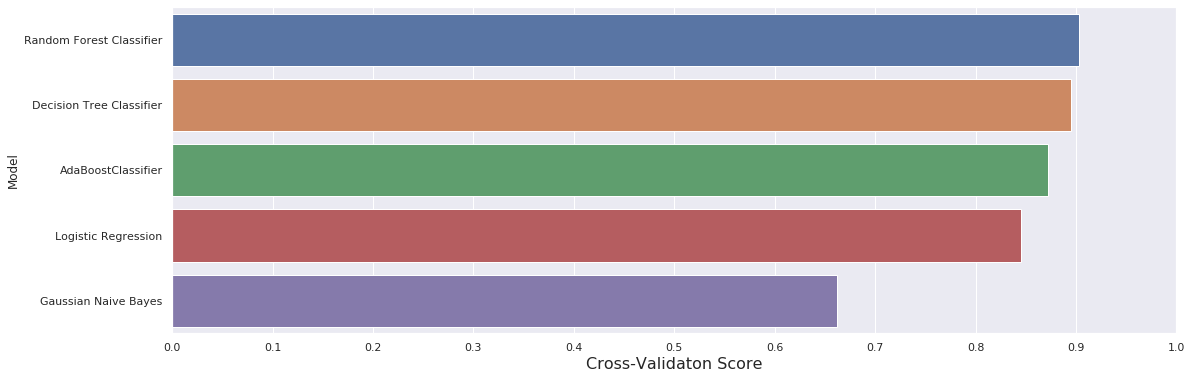

In [123]:
f, axe = plt.subplots(1,1, figsize=(18,6))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)
sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
axe.set_xticks(np.arange(0, 1.1, 0.1))
plt.show()